In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from scipy.fft import fft



In [25]:
# Loading the training datasets
accelerometer_train_data = pd.read_csv('/home/mzero/main/uni_repo/machine_learning_fqs_2024/ml4qs-gesture-recognition/Combined_100min_data/Combined_accelerometer_100min_with_lowpass.csv')
gyroscope_train_data = pd.read_csv('/home/mzero/main/uni_repo/machine_learning_fqs_2024/ml4qs-gesture-recognition/Combined_100min_data/Combined_gyroscope_100min_with_lowpass.csv')
linear_accelerometer_train_data = pd.read_csv('/home/mzero/main/uni_repo/machine_learning_fqs_2024/ml4qs-gesture-recognition/Combined_100min_data/Combined_linear_accelerometer_100min_with_lowpass.csv')
magnetometer_train_data = pd.read_csv('/home/mzero/main/uni_repo/machine_learning_fqs_2024/ml4qs-gesture-recognition/Combined_100min_data/Combined_magnetometer_100min_with_lowpass.csv')

In [26]:
# Loading the test datasets
accelerometer_test_data = pd.read_csv('/home/mzero/main/uni_repo/machine_learning_fqs_2024/ml4qs-gesture-recognition/Combined_40min_test/Combined_accelerometer_40min_with_lowpass.csv')
gyroscope_test_data = pd.read_csv('/home/mzero/main/uni_repo/machine_learning_fqs_2024/ml4qs-gesture-recognition/Combined_40min_test/Combined_gyroscope_40min_with_lowpass.csv')
linear_accelerometer_test_data = pd.read_csv('/home/mzero/main/uni_repo/machine_learning_fqs_2024/ml4qs-gesture-recognition/Combined_40min_test/Combined_linear_accelerometer_40min_with_lowpass.csv')
magnetometer_test_data = pd.read_csv('/home/mzero/main/uni_repo/machine_learning_fqs_2024/ml4qs-gesture-recognition/Combined_40min_test/Combined_magnetometer_40min_with_lowpass.csv')

### Transformation

In [27]:
# Merge datasets on time and label columns - syncronizing to same time point. (train)
train_df_1 = pd.merge(accelerometer_train_data, gyroscope_train_data, on=['time', 'label'])
train_df_2 = pd.merge(train_df_1, linear_accelerometer_train_data, on=['time', 'label'])
train_df_3 = pd.merge(train_df_2, magnetometer_train_data, on=['time', 'label'])

In [28]:
# Merge datasets on time and label columns - syncronizing to same time point. (test)
test_df_1 = pd.merge(accelerometer_test_data, gyroscope_test_data, on=['time', 'label'])
test_df_2 = pd.merge(test_df_1, linear_accelerometer_test_data, on=['time', 'label'])
test_df_3 = pd.merge(test_df_2, magnetometer_test_data, on=['time', 'label'])

##### Fourier Transformation --> Normalization Method: X

###### Fourier Transform

In [29]:

# Applying Fast Fourier Transformation - Discrete fourier Transformation
def apply_dft(df):
    features_X = df.columns.difference(['time', 'label'])
    df[features_X] = np.abs(fft(df[features_X], axis=1))

    return df 

train_df_X = apply_dft(train_df_3)
test_df_X = apply_dft(test_df_3)      

In [35]:
# Normalize the data
def normalizer(df):
    features_X = df.columns.difference(['time', 'label'])
    scaler = StandardScaler()
    df[features_X] = scaler.fit_transform(df[features_X])

    # Encode labels
    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])

    # Verify the unique classes
    print(f"Classes: {label_encoder.classes_}")
    print(f"Number of classes: {label_encoder.classes_.shape[0]}")

    return df, label_encoder

# Normalize the data and encode labels, returning both the DataFrame and the LabelEncoder
train_data_X, train_label_encoder = normalizer(train_df_X)
test_data_X, test_label_encoder = normalizer(test_df_X)



Classes: [0 1 2 3]
Number of classes: 4
Classes: [0 1 2 3]
Number of classes: 4


In [36]:

time_steps = 50  # Number of time steps used in LSTM
features = train_df_3.columns.difference(['time', 'label'])

# Prepare training data
time_steps = 50  # Number of time steps to look back
X_train = []
y_train = []

for i in range(time_steps, len(train_data_X)):
    X_train.append(train_data_X.iloc[i-time_steps:i][features].values.flatten())
    y_train.append(train_data_X.iloc[i]['label'])

X_train, y_train = np.array(X_train), np.array(y_train)


# Prepare test data
X_test = []
y_test = []

for i in range(time_steps, len(test_data_X)):
    X_test.append(test_data_X.iloc[i-time_steps:i][features].values.flatten())
    y_test.append(test_data_X.iloc[i]['label'])

X_test, y_test = np.array(X_test), np.array(y_test)

### Support Vector Machine Model

In [37]:
# Train the SVM model
svm_model = SVC(kernel='rbf', C=1, gamma='scale')  # You can tune the hyperparameters
svm_model.fit(X_train, y_train)


SVC(C=1)

In [40]:
# Make predictions on the test set
y_pred_svm = svm_model.predict(X_test)

# Convert label encoder classes to strings for classification report
target_names = [str(cls) for cls in test_label_encoder.classes_]

# Print classification report
print("SVM Classification Report")
print(classification_report(y_test, y_pred_svm, target_names=target_names))

# Calculate accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'SVM Model Accuracy: {accuracy_svm:.4f}')


SVM Classification Report
              precision    recall  f1-score   support

           0       0.63      0.75      0.68      1190
           1       0.74      0.76      0.75      1147
           2       0.00      0.00      0.00      1194
           3       0.33      0.51      0.40      1186

    accuracy                           0.50      4717
   macro avg       0.43      0.50      0.46      4717
weighted avg       0.42      0.50      0.46      4717

SVM Model Accuracy: 0.5005


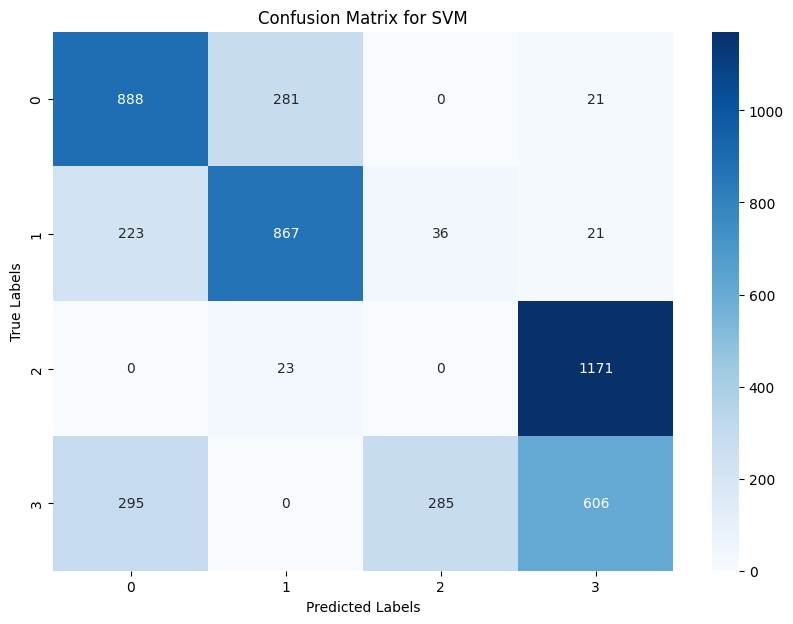

In [44]:
# Calculate confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

def plot_confusion_matrix(conf_matrix, classes, model_name):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Plot confusion matrix for SVM
plot_confusion_matrix(conf_matrix_svm, target_names, 'SVM')
